In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, \
    ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from google.colab import drive
drive.mount('/content/drive')

# Append the directory to your python path using sys
prefix = '/content/drive/My Drive/'
# Modify this to point directly to your "Colab Notebooks" directory
customized_path_to_your_dataset = 'Colab Notebooks/'

# Construct the system path
sys_path = prefix + customized_path_to_your_dataset
sys.path.append(sys_path)

# Define the file path for the dataset using os.path.join
fp_dataset = os.path.join(sys_path, 'dataset-of-10s.csv')
print('Path to dataset-of-10s.csv:', fp_dataset)

# Now, you can load your dataset using pandas
data = pd.read_csv(fp_dataset)
print(data.head())  # Display the first few rows of the dataset to confirm it's loaded correctly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path to dataset-of-10s.csv: /content/drive/My Drive/Colab Notebooks/dataset-of-10s.csv
                                 track                          artist  \
0                          Wild Things                    Alessia Cara   
1                            Surfboard                       Esquivel!   
2                         Love Someone                    Lukas Graham   
3  Music To My Ears (feat. Tory Lanez)                   Keys N Krates   
4        Juju On That Beat (TZ Anthem)  Zay Hilfigerrr & Zayion McCall   

                                    uri  danceability  energy  key  loudness  \
0  spotify:track:2ZyuwVvV6Z3XJaXIFbspeE         0.741   0.626    1    -4.826   
1  spotify:track:61APOtq25SCMuK0V5w2Kgp         0.447   0.247    5   -14.661   
2  spotify:track:2JqnpexlO9dmvjUMCaLCLJ         0.550   0.415    9    -6.557   
3  spotify:track:0c

Load the dataset

In [ ]:

X = data.drop(['track', 'artist', 'uri', 'target'], axis=1)
y = data['target']

Preprocessing pipeline

In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, X.columns)
])

Model pipeline

In [ ]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(GradientBoostingClassifier(), threshold='median')),
    ('classifier', GradientBoostingClassifier())
])

Hyperparameter tuning

In [ ]:
param_dist = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 1.0]
}
random_search = RandomizedSearchCV(model, param_dist, n_iter=10, cv=3, scoring='precision', verbose=3, random_state=42,
                                   n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


Evaluating the best model

In [ ]:
predictions = best_model.predict(X_test)
predicted_probs = best_model.predict_proba(X_test)[:, 1]
print("Best parameters:", random_search.best_params_)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, predicted_probs))

Best parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       655
           1       0.80      0.87      0.84       625

    accuracy                           0.83      1280
   macro avg       0.84      0.84      0.83      1280
weighted avg       0.84      0.83      0.83      1280

[[522 133]
 [ 79 546]]
ROC AUC Score: 0.9140726717557252


Plot ROC Curve

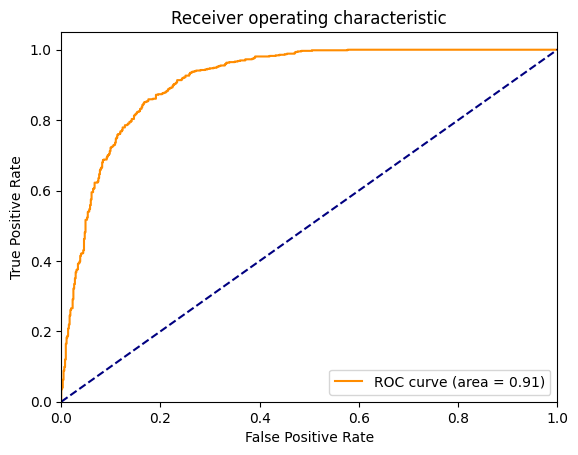

In [ ]:
fpr, tpr, _ = roc_curve(y_test, predicted_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, predicted_probs))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Define additional models

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
svc = SVC(probability=True, kernel='linear', random_state=42)
log_reg = LogisticRegression(max_iter=10000, solver='lbfgs', random_state=42)
gb = best_model  # using best_model for Gradient Boosting

In [ ]:
rf.fit(X_train, y_train)  # Fit RandomForest with training data
svc.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
# Voting Classifier setup
voting_clf = VotingClassifier(
    estimators=[('gb', gb), ('rf', rf), ('svc', svc), ('log_reg', log_reg)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)  # Fit the Voting Classifier on the training data

VotingClassifier(estimators=[('gb',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('num',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('poly',
                                                                                                 PolynomialFeatures()),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence'...
      dtype='object'))])),
                                              ('feature_selector',
                                               SelectFromModel(estimator=GradientBoostingClassifier(),
                                                               threshold='median')),
                                              ('classifier',
                                               GradientBoostingClassifier(max_depth=5,
                                                                          subsample=0.8))])),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc',
                              SVC(kernel='linear', probability=True,
                                  random_state=42)),
                             ('log_reg',
                              LogisticRegression(max_iter=10000,
                                                 random_state=42))])

Evaluating all models

In [ ]:
def get_model_probabilities(model, X_test):
    """Get model probabilities. Handles decision_function if predict_proba is unavailable."""
    try:
        if hasattr(model, 'predict_proba'):
            return model.predict_proba(X_test)[:, 1]
        elif hasattr(model, 'decision_function'):
            df = model.decision_function(X_test)
            return (df - df.min()) / (df.max() - df.min())  # Scale to [0,1]
        else:
            raise ValueError(f"{model.__class__.__name__} does not support probability or decision function.")
    except Exception as e:
        print(f"Error in getting model probabilities: {e}")
        return None

Evaluate and plot ROC AUC for each model

In [ ]:
models = [
    ('Gradient Boosting', best_model),
    ('Random Forest', rf),
    ('SVM', svc),
    ('Logistic Regression', log_reg),
    ('Voting Classifier', voting_clf)
]

In [ ]:
plt.figure(figsize=(10, 8))

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

Error in getting model probabilities: VotingClassifier does not support probability or decision function.


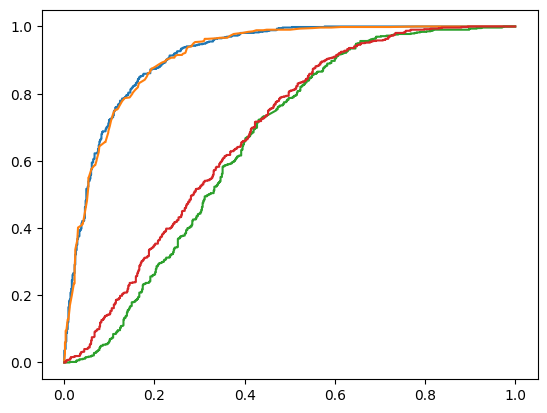

In [ ]:
for name, model in models:
    probas = get_model_probabilities(model, X_test)
    if probas is not None:
        fpr, tpr, _ = roc_curve(y_test, probas)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

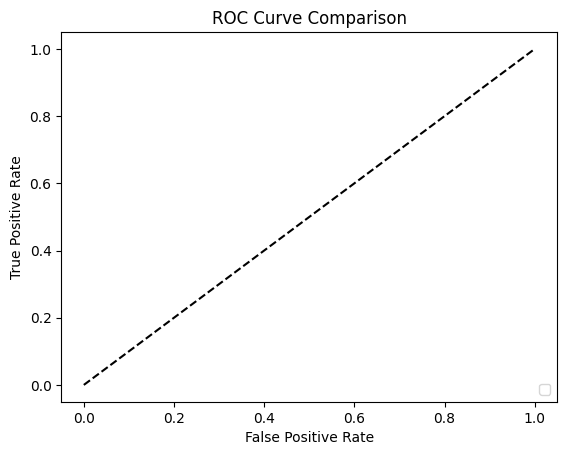

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Plot Precision-Recall curve for each model

Error in getting model probabilities: VotingClassifier does not support probability or decision function.


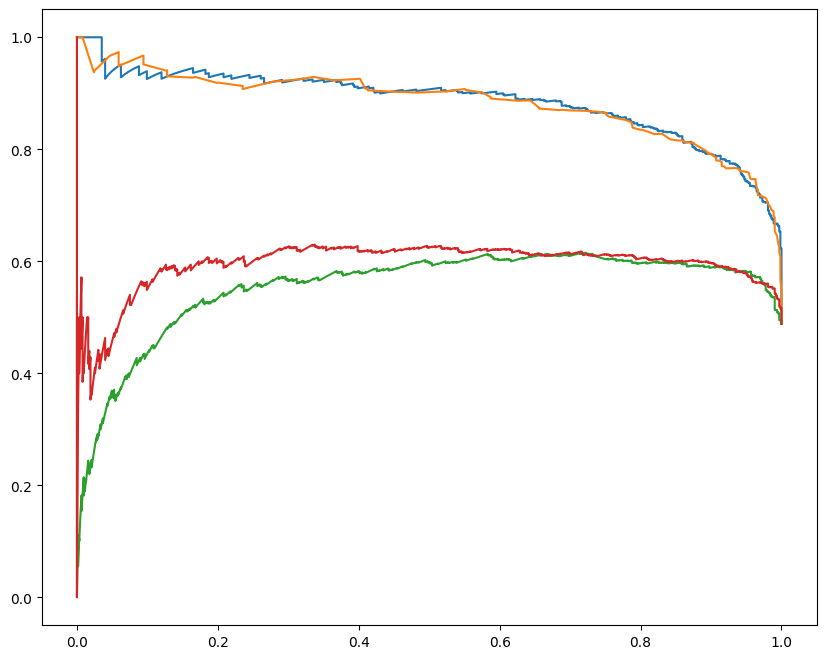

In [ ]:
plt.figure(figsize=(10, 8))
for name, model in models:
    probas = get_model_probabilities(model, X_test)
    if probas is not None:
        precision, recall, _ = precision_recall_curve(y_test, probas)
        ap = average_precision_score(y_test, probas)
        plt.plot(recall, precision, label=f'{name} (AP = {ap:.2f})')

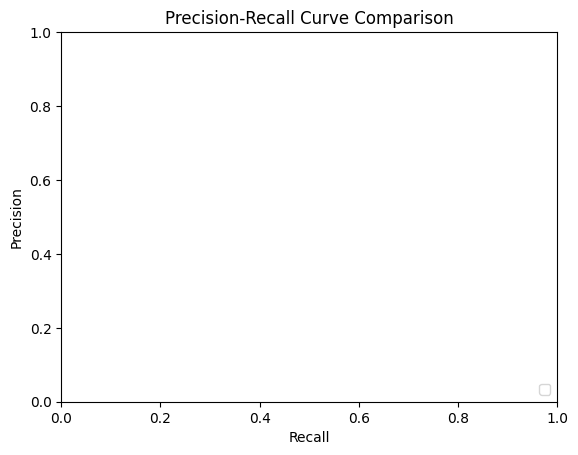

In [ ]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='lower right')
plt.show()

Plot learning curve for the best model

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, cv=3,
                                                        train_sizes=np.linspace(.1, 1.0, 5), verbose=0)

In [ ]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

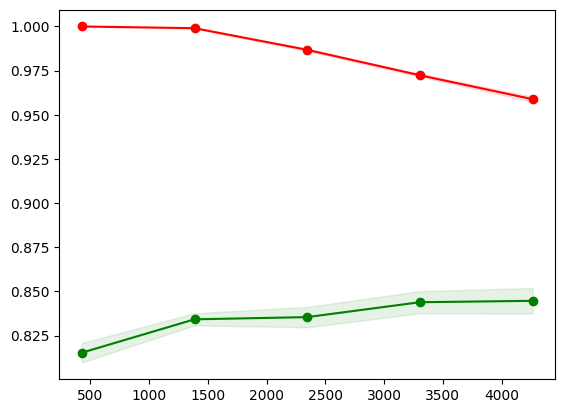

In [ ]:
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

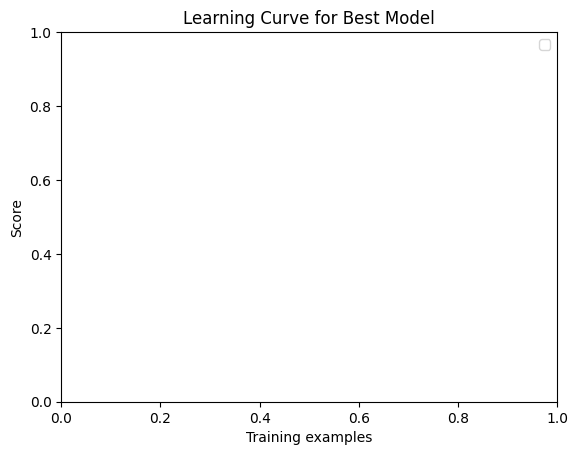

In [ ]:
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve for Best Model")
plt.legend(loc="best")
plt.show()

Confusion Matrix for best model using ConfusionMatrixDisplay

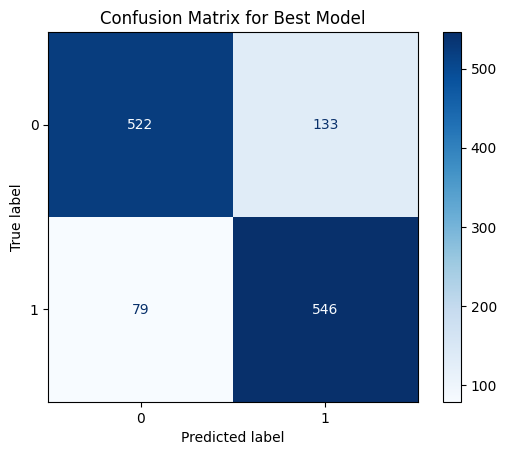

In [ ]:
cm = confusion_matrix(y_test, best_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Best Model')
plt.show()

Heatmap of the confusion matrix for the best model

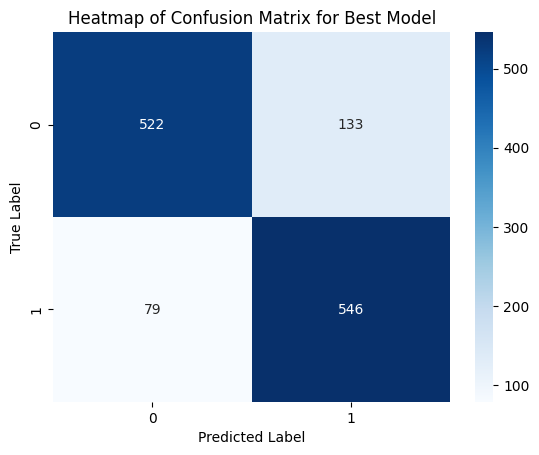

In [ ]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Heatmap of Confusion Matrix for Best Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()